<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-TF-enrichments-for-top-20-genes-in-each-component" data-toc-modified-id="Get-TF-enrichments-for-top-20-genes-in-each-component-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get TF enrichments for top 20 genes in each component</a></span></li><li><span><a href="#Sensitivity-Analysis" data-toc-modified-id="Sensitivity-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sensitivity Analysis</a></span></li></ul></div>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import pandas as pd
import numpy as np
import sys
sys.path.append('../../scripts')

In [2]:
from enrichments import *
from core import *

In [3]:
datasets = sorted([x for x in os.listdir(os.path.join(DATA_DIR,'iModulons'))
            if '.' not in x])

In [4]:
def load(dataset):
    # Define directories
    ds_dir = os.path.join(DATA_DIR,'iModulons',dataset)
    
    # Define files
    X_file = os.path.join(DATA_DIR,'processed_data',dataset+'.csv')
    M_file = os.path.join(ds_dir,'M.csv')
    A_file = os.path.join(ds_dir,'A.csv')
    metadata_file = os.path.join(DATA_DIR,'metadata',dataset+'_metadata.csv')
    
    return IcaData(M_file,A_file,X_file,metadata_file)

In [5]:
# Load datasets
objs = {}
for dataset in datasets:
    objs[dataset] = load(dataset)

# Get TF enrichments for top 20 genes in each component

In [6]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

def get_initial_enrichments(ica_data):

    list2struct = []
    comp_genes = {}

    all_genes = set(ica_data.M.index)
    for k in tqdm(ica_data.M.columns):
        genes = set(abs(ica_data.M[k]).sort_values().iloc[-20:].index)

        enrichments = compute_enrichments(
            genes, all_genes, trn, fdr=1e-5)
        enrichments['TF'] = enrichments.index
        enrichments['comp'] = k
        enrichments['n_genes'] = len(genes)

        list2struct.append(enrichments.reset_index(drop=True))
    DF_enriched = pd.concat(list2struct, sort=False).reset_index(drop=True)
    DF_enriched = DF_enriched[['comp', 'TF', 'log_odds', 'f1score',
                               'pvalue', 'precision', 'recall', 'TP', 'n_genes']]
    
    # Sort by p-value
    DF_high_conf = DF_enriched.sort_values(['comp','pvalue']).drop_duplicates('comp')
    return DF_high_conf

In [7]:
init_enrich = {}
for key,obj in objs.items():
    init_enrich[key] = get_initial_enrichments(obj)

# Sensitivity Analysis
To ensure that out cutoff is correct, we can scan across various cutoffs to identify the best results. 

In [8]:
def sensitivity_analysis(ica_data,enrich,title):
    precision = []
    recall = []
    fpr = []
    custom = []
    f1_score = []
    all_genes = set(ica_data.M.index)

    vals = range(200,1000,50)
    for cutoff in tqdm(vals):
        prec = []
        rec = []
        f1_i = []
        fpr_i = []

        for i,row in enrich.iterrows():

            ic_genes = set(ica_data.M[abs(ica_data.M[row.comp]) >
                                      compute_threshold(ica_data.M,row.comp,cutoff)].index)
            reg_genes = set(trn[trn.TF == row.TF].gene_id)
            ((tp_i,fp_i),(fn_i,tn_i)) = contingency(reg_genes,ic_genes,all_genes)

            # Calculate metrics for one regulator-component pair
            if tp_i + fp_i != 0:
                prec_tmp = np.true_divide(tp_i,tp_i+fp_i)
                rec_tmp = np.true_divide(tp_i,tp_i+fn_i)
            else:
                prec_tmp = 0
                rec_tmp = 0
            f1_tmp = (2*prec_tmp*rec_tmp)/(prec_tmp+rec_tmp) if prec_tmp + rec_tmp > 0 else 0
            fpr_tmp = np.true_divide(fp_i,fp_i+tn_i)

            # Add to list for this cutoff score
            prec.append(prec_tmp)
            rec.append(rec_tmp)
            f1_i.append(f1_tmp)
            fpr_i.append(fpr_tmp)

        # Get mean of metric for this cutoff score
        precision.append(np.mean(prec))
        recall.append(np.mean(rec))
        fpr.append(np.mean(fpr_i))
        f1_score.append(np.mean(f1_i))
        
    # Plot final values
    fig,ax = plt.subplots(1,3,figsize=(10,3))
    ax[0].set_ylabel('Average F1-score',fontsize=12)
    ax[0].set_xlabel("D'Agostino statistic cutoff",fontsize=12)
    ax[0].plot(vals,f1_score,color='k')
    ax[0].scatter([vals[np.argmax(f1_score)]],[f1_score[np.argmax(f1_score)]],color='r')
    ax[0].set_ylim([0.3,0.6])
    ax[0].set_xlim([200,1000])
    ax[0].set_title('Cutoff vs F1-score: '+title,fontsize=12)
    
    # Plot ROC curve
    ax[1].plot(fpr,recall,color='k')
    ax[1].scatter([fpr[np.argmax(f1_score)]],[recall[np.argmax(f1_score)]],color='r')
    ax[1].set_xlabel('False Positive Rate',fontsize=12)
    ax[1].set_ylabel('True Positive Rate',fontsize=12)
    ax[1].set_xlim([-0.02,1])
    ax[1].set_ylim([0,1])
    ax[1].set_title('ROC Curve: '+title,fontsize=12)
    
    # Plot Precision-recall curve
    ax[2].plot(recall,precision,color='k')
    ax[2].scatter([recall[np.argmax(f1_score)]],[precision[np.argmax(f1_score)]],color='r')
    ax[2].set_xlabel('Recall',fontsize=12)
    ax[2].set_ylabel('Precision',fontsize=12)
    ax[2].set_xlim([-0.02,1])
    ax[2].set_ylim([0,1])
    ax[2].set_title('Precision-Recall Curve: '+title,fontsize=12)
    plt.tight_layout()
    
    return vals[np.argmax(f1_score)]

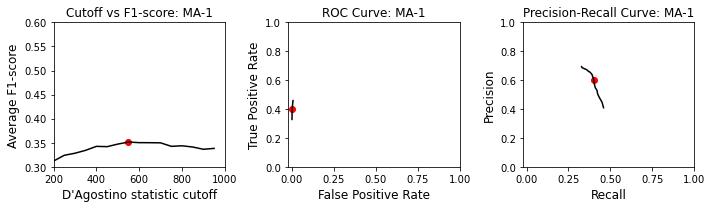

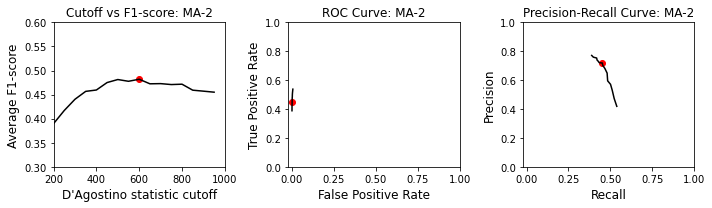

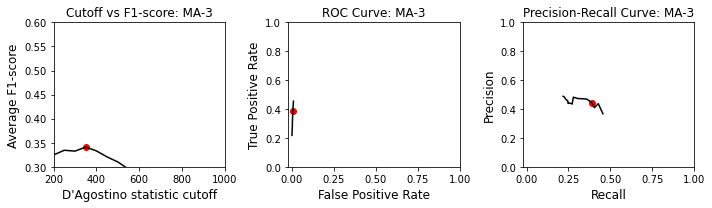

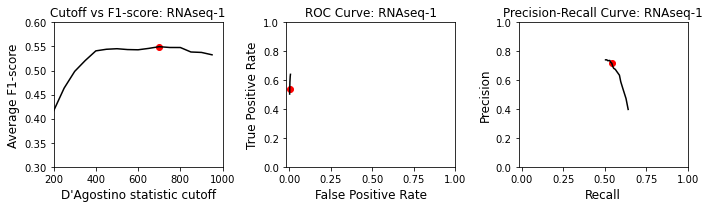

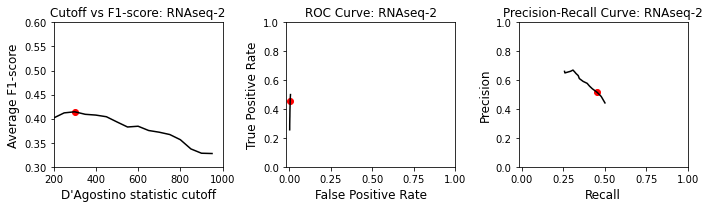

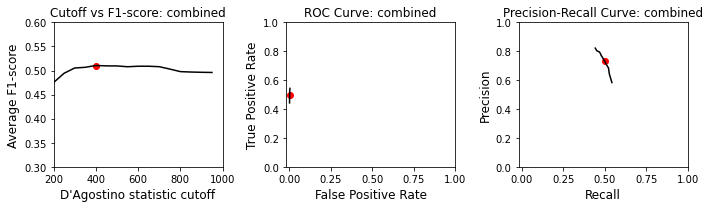

In [9]:
cutoffs = {}
for key in objs.keys():
    cutoffs[key] = sensitivity_analysis(objs[key],init_enrich[key],key)

In [10]:
cutoffs

{'MA-1': 550,
 'MA-2': 600,
 'MA-3': 350,
 'RNAseq-1': 700,
 'RNAseq-2': 300,
 'combined': 400}